# Creación del modelo benigno o maligno

## Datos de las imagenes.

Todas las imagenes han salido de juntar dos conjuntos de kaggle en uno solo estos son los enlaces:
- Benignos o malignos1: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
- Benignos o malignos2: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign?select=train


En este colab estamos creando un modelo para clasificar distinto tipos de imagenes de piel para saber si tienen un cancer benigno o maligno.

## Hacemos las instalaciones y las importaciones.

In [1]:
pip install numpy

In [2]:
pip install scipy

In [3]:
pip install scikit-learn

In [69]:
import numpy as np
import pandas as pd
import zipfile
import scipy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.applications import DenseNet121
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from keras.applications import InceptionV3, ResNet50, MobileNetV2
from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
%matplotlib inline

## Extraer las imagenes

Extraemos todas las imagenes de un archivo zip alojado en drive y la descomprimimos en una variable llamada train_dir eso contiene dos carpetas que seran las dos clases de imagenes que hay y todas las imagenes dentro de su respectiva carpeta.

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Ruta del archivo ZIP en Google Drive
ruta_archivo_zip = '/content/drive/MyDrive/dataset/super_benigno_vs_maligno.zip'

# Ruta donde deseas extraer los archivos
ruta_destino = '/content/extracted/'

# Descomprime el contenido del ZIP
with zipfile.ZipFile(ruta_archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(ruta_destino)

# Lista los archivos extraídos
archivos_extraidos = os.listdir(ruta_destino)
print(f'Archivos extraídos: {archivos_extraidos}')

# Ruta de la carpeta que contiene las imágenes
train_dir = os.path.join(ruta_destino, 'super_benigno_vs_maligno')

# Verifica la existencia de la carpeta antes de listar los archivos
if os.path.exists(train_dir):
    archivos_en_carpeta = os.listdir(train_dir)
    print(f'Archivos en la carpeta: {archivos_en_carpeta}')
else:
    print(f'La carpeta {train_dir} no existe.')

# Lista de nombres de archivos en la carpeta
skin = os.listdir(train_dir)

Archivos extraídos: ['super_benigno_vs_maligno']
Archivos en la carpeta: ['benign', 'malignant']


## Muestras de los datos.

In [60]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for s in skin:
    nums_train[s] = len(os.listdir(train_dir + '/' + s))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


no. of images
benign             13050
malignant          11152

<Axes: title={'center': 'data distribution '}, xlabel='Type of skin cancer', ylabel='Number of image'>

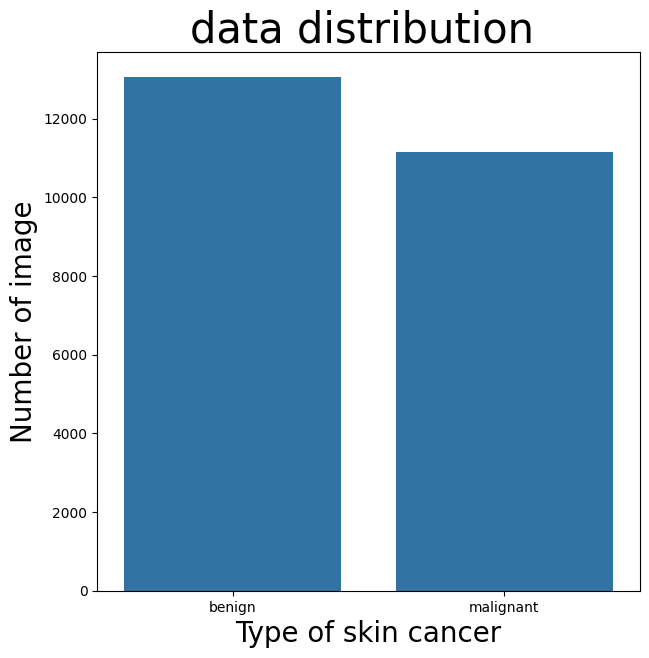

In [65]:
plt.figure(figsize=(7,7))
plt.title('data distribution ',fontsize=30)
plt.ylabel('Number of image',fontsize=20)
plt.xlabel('Type of skin cancer',fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)

Podemos ver que las dos clases estan aproximadamente balanceadas

In [70]:
# Function to show image
train = ImageFolder(train_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

### Muestra de imagenes benignas.

Label :benign(0)
Label :benign(0)
Label :benign(0)
Label :benign(0)
Label :benign(0)
Label :benign(0)


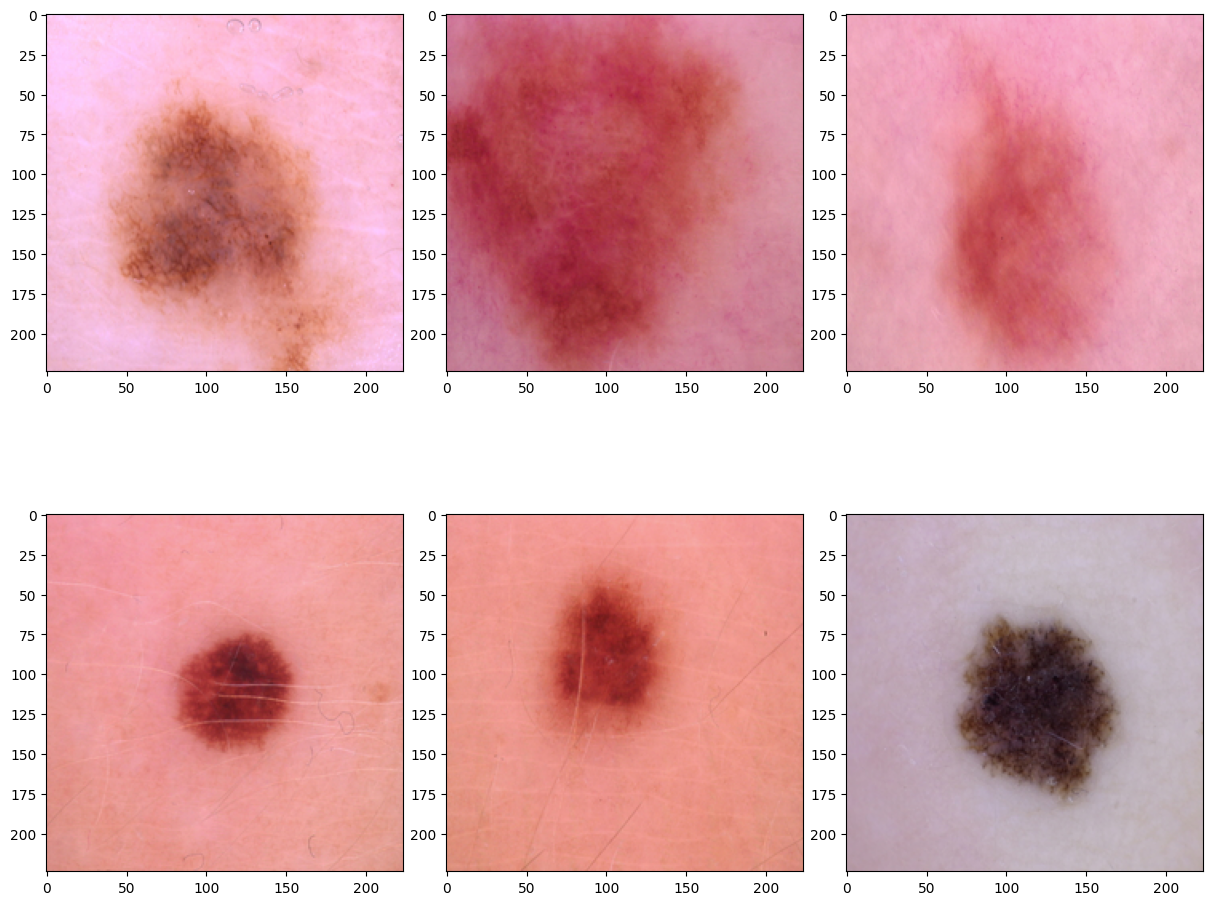

In [71]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[1]))
axs[0,1].imshow(show_image(*train[260]))
axs[1, 0].imshow(show_image(*train[850]))
axs[1,1].imshow(show_image(*train[930]))
axs[0,2].imshow(show_image(*train[1250]))
axs[1,2].imshow(show_image(*train[1380]))

### Muestras de imagenes malignas

Label :malignant(1)
Label :malignant(1)
Label :malignant(1)
Label :malignant(1)
Label :malignant(1)
Label :malignant(1)


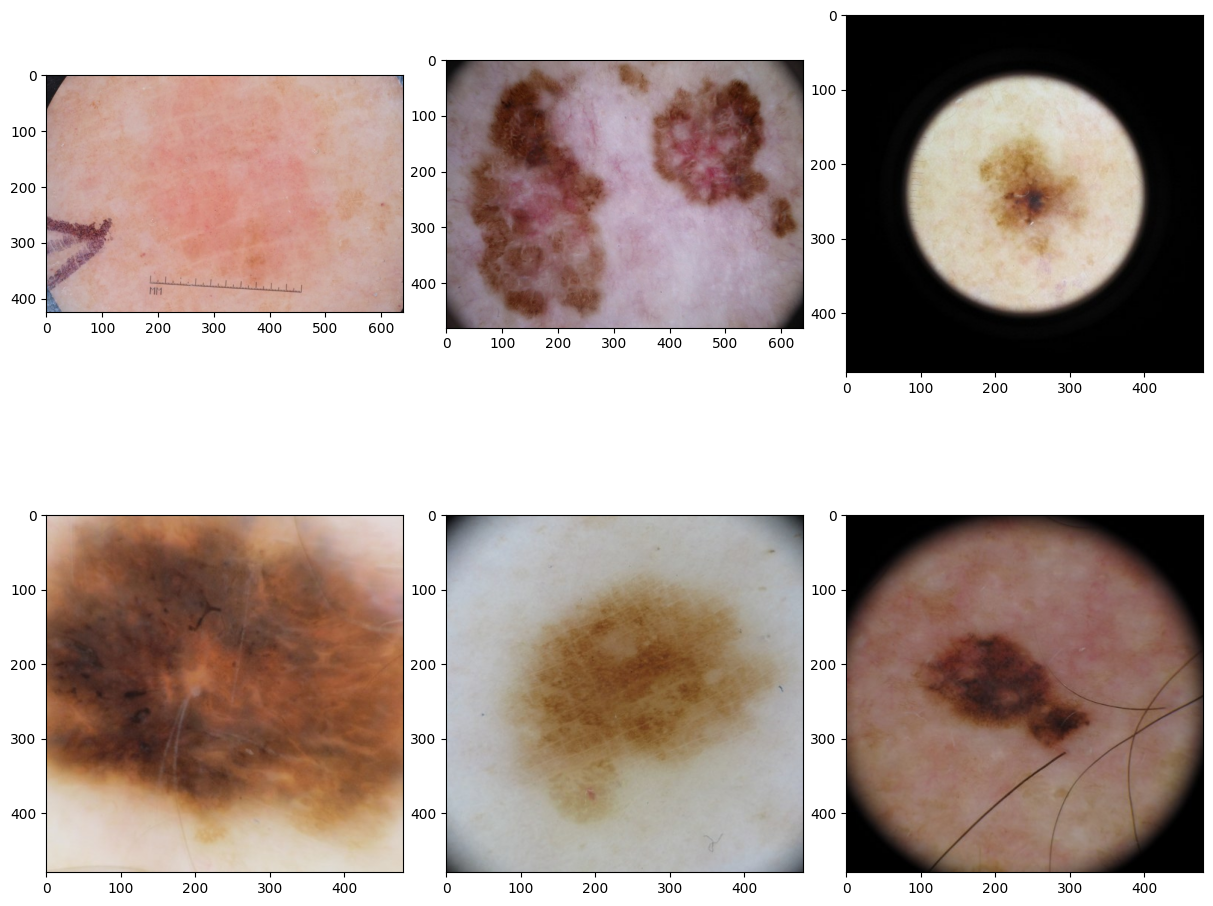

In [73]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[15000]))
axs[0,1].imshow(show_image(*train[15500]))
axs[1, 0].imshow(show_image(*train[16000]))
axs[1,1].imshow(show_image(*train[16500]))
axs[0,2].imshow(show_image(*train[17000]))
axs[1,2].imshow(show_image(*train[17500]))

## Redimensionamiento de imagenes y transformacion

En este bloque de codigo estamos redimensionando las imagenes a un tamaño de 150 x 150, despues concatenamos todos los datos en arrays.

In [7]:
def redimensionar_imagen(ruta, nuevo_tamano):
    imagen = Image.open(ruta)
    imagen_redimensionada = imagen.resize(nuevo_tamano)
    arreglo_pixeles_redimensionado = np.array(imagen_redimensionada)
    return arreglo_pixeles_redimensionado

# Definir el nuevo tamaño deseado
nuevo_tamano = (150, 150)

# Redimensionar las imágenes de entrenamiento benignas
datos_train_piel_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'benign', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'benign'))]

# Redimensionar las imágenes de entrenamiento malignas
datos_train_objeto_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'malignant', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'malignant'))]

# Asegurarse de que todas las imágenes tengan el mismo tamaño
datos_train_piel_redimensionados = np.array([img for img in datos_train_piel_redimensionados if img.shape == (150, 150, 3)])
datos_train_objeto_redimensionados = np.array([img for img in datos_train_objeto_redimensionados if img.shape == (150, 150, 3)])

# Concatenar los datos de ambas clases
datos_train_redimensionados = np.concatenate([datos_train_piel_redimensionados, datos_train_objeto_redimensionados], axis=0)

# Crear etiquetas correspondientes
etiquetas_train_redimensionadas = np.concatenate([np.zeros(len(datos_train_piel_redimensionados)), np.ones(len(datos_train_objeto_redimensionados))], axis=0)

Aqui estamos dividiendo los datos para tener los datos de entrenamiento y test y sus etiquetas correspondientes, tambien normalizamos los pixeles diviendo entre 255 y convertimos la etiquetas a un formato one-hot.

In [8]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_redimensionados, etiquetas_train_redimensionadas, test_size=0.2, random_state=42)


# Normalizar los píxeles dividiendo por 255
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convertir etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

## Preparacion para los modelos.

 - En el siguiente bloque de codigo lo que tenemos es una clase CustomLearningRateScheduler que lo que hace es a la hora del callback  llama a esta clase para ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento de un modelo, la metrica que se esta monitoreando es el Val_accuracy con una paciencia de 1 epoca. Eso significa que si el val_accuracy de una epoca a otra a desminuido se ejecuta la clase disminuyendo el learning rate dividiendolo entre /2 eso significa que si antes teniamos 0.0001 ahora tendriamos 0.0005.

- Tambien tenemos un checkpoint que va guardando el modelo cada vez que mejora el val_accuracy porque muchas veces pasa que durante el entrenamiento ha habido alguna epoca mejor que la ultima donde ha terminado el modelo su entrenamiento.

- Por ultimo se esta haciendo un ImageDataGenerator que se encarga de realizar aumento de datos y preprocesamiento para conjuntos de entrenamiento y prueba en un problema de clasificación de imágenes. Esto es especialmente útil para mejorar la capacidad de generalización del modelo al exponerlo a variaciones en los datos durante el entrenamiento. El aumento de datos ayuda a prevenir el sobreajuste al proporcionar más variabilidad en el conjunto de entrenamiento.

In [76]:
class CustomLearningRateScheduler(Callback):
    def __init__(self, factor=0.5, patience=1, min_lr=1e-12):
        super(CustomLearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.current_lr = None

    def on_epoch_begin(self, epoch, logs=None):
        if self.current_lr is None:
            self.current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy', 0)

        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.wait = 0
            # Guardar el modelo cuando la precisión en el conjunto de validación mejora
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.current_lr * self.factor, self.min_lr)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                self.current_lr = new_lr  # Actualizar el valor actual de la tasa de aprendizaje
                print(f'Reverting learning rate to {new_lr}')
                self.wait = 0

# Crear el callback CustomLearningRateScheduler
custom_lr_scheduler = CustomLearningRateScheduler(factor=0.5, patience=1, min_lr=1e-12)

# Callback para guardar el modelo con la mejor precisión en el conjunto de validación
model_checkpoint = ModelCheckpoint('best_model_checkpoint.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Aumento de datos para el conjunto de entrenamiento y prueba
datagen_train = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator()

datagen_train.fit(X_train)
datagen_test.fit(X_test)

# Convertir etiquetas a one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

# Generador de imágenes aumentadas para el conjunto de entrenamiento
train_generator = datagen_train.flow(X_train, y_train_one_hot, batch_size=32)

# Generador de imágenes para el conjunto de prueba
test_generator = datagen_test.flow(X_test, y_test_one_hot, batch_size=32)


## Modelos.

Aqui hemos creado 5 modelos para ver en nuestro caso cual es el mas util comprobando su val_accuracy y viendo donde tiene mas fallos.
Hemos utilizado 5 modelos preentrenados que son:  InceptionV3, DenseNet121, ResNet50, VGG16 y  MobileNetV2.

### Modelo InceptionV3:
- Val Accuracy: 0.9334848171865318
- [[2479  108]
- [214 2040]]

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3), pooling='max')


# Agregar capas personalizadas
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Crear el modelo
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compilar el modelo con el optimizador Adam y el callback ReduceLROnPlateau
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo utilizando el generador de datos aumentados para el conjunto de entrenamiento
model.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[custom_lr_scheduler, model_checkpoint])

Epoch 1/20
606/606 [==============================] - ETA: 0s - loss: 0.4309 - accuracy: 0.8228

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


606/606 [==============================] - 122s 157ms/step - loss: 0.4309 - accuracy: 0.8228 - val_loss: 0.2784 - val_accuracy: 0.8833
Epoch 2/20
606/606 [==============================] - 94s 155ms/step - loss: 0.2993 - accuracy: 0.8773 - val_loss: 0.2511 - val_accuracy: 0.8959
Epoch 3/20
606/606 [==============================] - 94s 155ms/step - loss: 0.2649 - accuracy: 0.8924 - val_loss: 0.2363 - val_accuracy: 0.9039
Epoch 4/20
606/606 [==============================] - 95s 156ms/step - loss: 0.2442 - accuracy: 0.9019 - val_loss: 0.2288 - val_accuracy: 0.9064
Epoch 5/20
606/606 [==============================] - 94s 155ms/step - loss: 0.2295 - accuracy: 0.9067 - val_loss: 0.2319 - val_accuracy: 0.9087
Epoch 6/20
606/606 [==============================] - 92s 152ms/step - loss: 0.2179 - accuracy: 0.9137 - val_loss: 0.2404 - val_accuracy: 0.9029
Epoch 7/20
606/606 [==============================] - 93s 154ms/step - loss: 0.1922 - accuracy: 0.9241 - val_loss: 0.2045 - val_accuracy: 0.

### Modelo DenseNet121:
- Val Accuracy: 0.9310059904978311
- [[2498   89]
- [245 2009]]

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3), pooling='max')


# Agregar capas personalizadas
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Crear el modelo
model2 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compilar el modelo con el optimizador Adam y el callback ReduceLROnPlateau
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo utilizando el generador de datos aumentados para el conjunto de entrenamiento
model2.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[custom_lr_scheduler, model_checkpoint])

Epoch 1/20
606/606 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.8258

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


606/606 [==============================] - 152s 164ms/step - loss: 0.5155 - accuracy: 0.8258 - val_loss: 0.3047 - val_accuracy: 0.8746
Epoch 2/20
606/606 [==============================] - 98s 161ms/step - loss: 0.2925 - accuracy: 0.8809 - val_loss: 0.2509 - val_accuracy: 0.8872
Epoch 3/20
606/606 [==============================] - 97s 159ms/step - loss: 0.2582 - accuracy: 0.8956 - val_loss: 0.2257 - val_accuracy: 0.9050
Epoch 4/20
606/606 [==============================] - 94s 155ms/step - loss: 0.2341 - accuracy: 0.9044 - val_loss: 0.3093 - val_accuracy: 0.8779
Epoch 5/20
606/606 [==============================] - 95s 156ms/step - loss: 0.2253 - accuracy: 0.9069 - val_loss: 0.2685 - val_accuracy: 0.8936
Epoch 6/20
606/606 [==============================] - 97s 160ms/step - loss: 0.2078 - accuracy: 0.9169 - val_loss: 0.2284 - val_accuracy: 0.9087
Epoch 7/20
606/606 [==============================] - 94s 155ms/step - loss: 0.2004 - accuracy: 0.9189 - val_loss: 0.2412 - val_accuracy: 0.

### Modelo ResNet50:
- Val Accuracy: 0.8686221854988638
- [[2564   23]
- [613 1641]]

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3), pooling='max')


# Agregar capas personalizadas
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Crear el modelo
model3 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-10:]:
    layer.trainable = True


# Compilar el modelo con el optimizador Adam y el callback ReduceLROnPlateau
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo utilizando el generador de datos aumentados para el conjunto de entrenamiento
model3.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[custom_lr_scheduler, model_checkpoint])

Epoch 1/20
606/606 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.8276

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


606/606 [==============================] - 123s 158ms/step - loss: 0.7078 - accuracy: 0.8276 - val_loss: 1.5194 - val_accuracy: 0.5916
Epoch 2/20
606/606 [==============================] - 94s 155ms/step - loss: 0.2954 - accuracy: 0.8821 - val_loss: 0.2544 - val_accuracy: 0.8986
Epoch 3/20
606/606 [==============================] - 93s 154ms/step - loss: 0.2629 - accuracy: 0.8945 - val_loss: 0.2518 - val_accuracy: 0.8955
Epoch 4/20
606/606 [==============================] - 94s 154ms/step - loss: 0.2373 - accuracy: 0.9060 - val_loss: 0.2460 - val_accuracy: 0.8938
Epoch 5/20
606/606 [==============================] - 96s 158ms/step - loss: 0.2217 - accuracy: 0.9124 - val_loss: 0.2368 - val_accuracy: 0.9042
Epoch 6/20
606/606 [==============================] - 94s 155ms/step - loss: 0.2127 - accuracy: 0.9151 - val_loss: 0.2198 - val_accuracy: 0.9091
Epoch 7/20
606/606 [==============================] - 92s 152ms/step - loss: 0.2023 - accuracy: 0.9161 - val_loss: 0.2456 - val_accuracy: 0.

### Modelo VGG16:
- Val Accuracy: 0.9555876884941128
- [[2497   90]
- [125 2129]]

In [77]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3), pooling='max')


# Agregar capas personalizadas
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Crear el modelo
model4 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-10:]:
    layer.trainable = True


# Compilar el modelo con el optimizador Adam y el callback ReduceLROnPlateau
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo utilizando el generador de datos aumentados para el conjunto de entrenamiento
history=model4.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[custom_lr_scheduler, model_checkpoint])

Epoch 1/20
606/606 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.8460

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


606/606 [==============================] - 96s 151ms/step - loss: 0.3550 - accuracy: 0.8460 - val_loss: 0.2862 - val_accuracy: 0.8779
Epoch 2/20
606/606 [==============================] - 92s 152ms/step - loss: 0.2840 - accuracy: 0.8826 - val_loss: 0.2709 - val_accuracy: 0.8798
Epoch 3/20
606/606 [==============================] - 91s 151ms/step - loss: 0.2659 - accuracy: 0.8890 - val_loss: 0.2360 - val_accuracy: 0.9044
Epoch 4/20
606/606 [==============================] - 91s 151ms/step - loss: 0.2448 - accuracy: 0.9001 - val_loss: 0.2536 - val_accuracy: 0.8913
Epoch 5/20
606/606 [==============================] - 91s 149ms/step - loss: 0.2192 - accuracy: 0.9115 - val_loss: 0.2114 - val_accuracy: 0.9147
Epoch 6/20
606/606 [==============================] - 92s 152ms/step - loss: 0.2079 - accuracy: 0.9163 - val_loss: 0.2061 - val_accuracy: 0.9176
Epoch 7/20
606/606 [==============================] - 92s 152ms/step - loss: 0.1975 - accuracy: 0.9188 - val_loss: 0.2051 - val_accuracy: 0.9

### Modelo MobileNetV2:
- Val Accuracy: 0.858087172071886
- [[2558   29]
- [658 1596]]

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3), pooling='max')

# Agregar capas personalizadas
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Crear el modelo
model5 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-10:]:
    layer.trainable = True


# Compilar el modelo con el optimizador Adam y el callback ReduceLROnPlateau
model5.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo utilizando el generador de datos aumentados para el conjunto de entrenamiento
model5.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[custom_lr_scheduler, model_checkpoint])

Epoch 1/20
606/606 [==============================] - 110s 150ms/step - loss: 0.7044 - accuracy: 0.7889 - val_loss: 2.2935 - val_accuracy: 0.6464
Epoch 2/20
606/606 [==============================] - 90s 148ms/step - loss: 0.3504 - accuracy: 0.8495 - val_loss: 0.8403 - val_accuracy: 0.7527
Epoch 3/20
606/606 [==============================] - 90s 148ms/step - loss: 0.3037 - accuracy: 0.8769 - val_loss: 0.3125 - val_accuracy: 0.8800
Epoch 4/20
606/606 [==============================] - 91s 150ms/step - loss: 0.2819 - accuracy: 0.8856 - val_loss: 0.2697 - val_accuracy: 0.8940
Epoch 5/20
606/606 [==============================] - 90s 148ms/step - loss: 0.2658 - accuracy: 0.8949 - val_loss: 0.2776 - val_accuracy: 0.8907
Epoch 6/20
606/606 [==============================] - 89s 147ms/step - loss: 0.2513 - accuracy: 0.8977 - val_loss: 0.2687 - val_accuracy: 0.8893
Epoch 7/20
606/606 [==============================] - 90s 149ms/step - loss: 0.2501 - accuracy: 0.8986 - val_loss: 0.2535 - val_a

### Resultado de los modelos:

Una vez que hemos entrando los 5 modelos estos han sido los resultados.


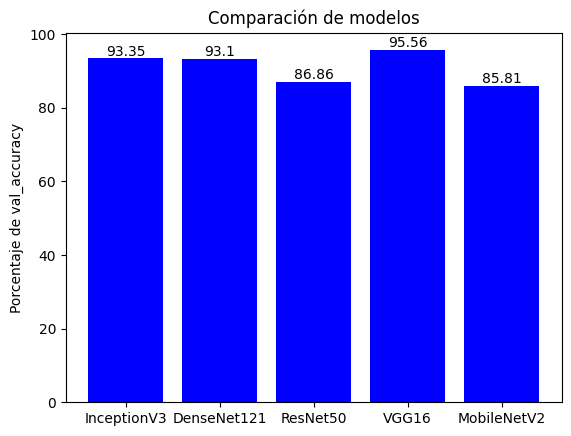

In [8]:
InceptionV3= 0.9334848171865318
DenseNet121=0.9310059904978311
ResNet50=0.8686221854988638
VGG16=0.9555876884941128
MobileNetV2= 0.858087172071886

# Multiplicar por 100
InceptionV3 *= 100
DenseNet121 *= 100
ResNet50 *= 100
VGG16 *= 100
MobileNetV2 *= 100

# Nombres de los modelos
model_names = ['InceptionV3', 'DenseNet121', 'ResNet50', 'VGG16', 'MobileNetV2']

# Valores multiplicados por 100
model_values = [InceptionV3, DenseNet121, ResNet50, VGG16, MobileNetV2]

# Crear la gráfica de barras
fig, ax = plt.subplots()
bars = ax.bar(model_names, model_values, color='blue')
plt.ylabel('Porcentaje de val_accuracy')
plt.title('Comparación de modelos')

# Agregar los valores encima de las columnas
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

Como podemos ver el mejor resultado ha sido el VGG16 con 95,56% de val_accuracy ese es el que hemos escogido.

## Grafico del mejor modelo

Figure(1200x400)


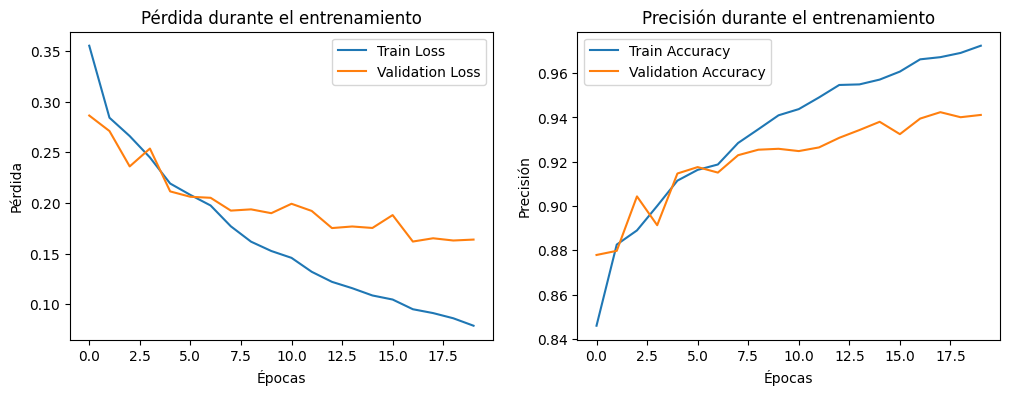

In [78]:
# Visualizar gráficos de pérdida y precisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de pérdida
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Pérdida durante el entrenamiento')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.legend()

# Gráfico de precisión
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Precisión durante el entrenamiento')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Precisión')
ax2.legend()

print(fig)

## Exportando el modelo.

Exportamos el modelo a drive en un formato .tflite ya que este formato pesa menos MG, ya que a la hora de subirlo al github solo se pueden subir archivos que pesen menos de 100MG

In [ ]:
# Convertir el modelo en un modelo compatible con TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model4)
tflite_model = converter.convert()

# Guardar el modelo TFLite en un archivo
with open('/content/drive/MyDrive/dataset/benigno_vs_maligno_mejorado12.tflite', 'wb') as f:
    f.write(tflite_model)

## Probando el modelo.

In [30]:
# Hacer predicciones con el modelo
y_pred = model4.predict(X_test)

# Obtener las clases predichas (índice de la clase con probabilidad más alta)

predicted_labels = np.argmax(y_pred, axis=1)

# Convertir las predicciones a etiquetas de clases (índices)
y_pred2 = y_pred.argmax(axis=1)

# Calcular el número de aciertos y fallos
correct_predictions = np.sum(predicted_labels == y_test)
incorrect_predictions = len(y_test) - correct_predictions

# Calcular la precisión
accuracy = correct_predictions / len(y_test)

# Imprimir resultados
print(f'Número de aciertos: {correct_predictions}')
print(f'Número de fallos: {incorrect_predictions}')
print(f'Accuracy: {accuracy}')

# Calcular métricas
y_test_classes = y_test.flatten()

# Calcular métricas
roc_auc = roc_auc_score(y_test_classes, predicted_labels)
conf_matrix = confusion_matrix(y_test_classes, predicted_labels)
class_report = classification_report(y_test_classes, predicted_labels)

# Imprimir métricas
print(f'AUC-ROC: {roc_auc:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

152/152 [==============================] - 3s 21ms/step
Número de aciertos: 4508
Número de fallos: 333
Accuracy: 0.9312125593885561
AUC-ROC: 0.93
Confusion Matrix:
[[2432  155]
 [ 178 2076]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      2587
         1.0       0.93      0.92      0.93      2254

    accuracy                           0.93      4841
   macro avg       0.93      0.93      0.93      4841
weighted avg       0.93      0.93      0.93      4841



Podemos ver aqui los valores resultantes de nuestro modelo con la clase de test, sus aciertos, fallos, val_accuracy, la confusion matrix y el classification report. Podemos ver que falla un poco mas en la segunda prediccion que serian fotos malignas con un resultado de 125 frente a las 90 fallos de prediccion de la clase benigna.

In [23]:
images_batch, labels_batch = next(test_generator)
len(images_batch)

32

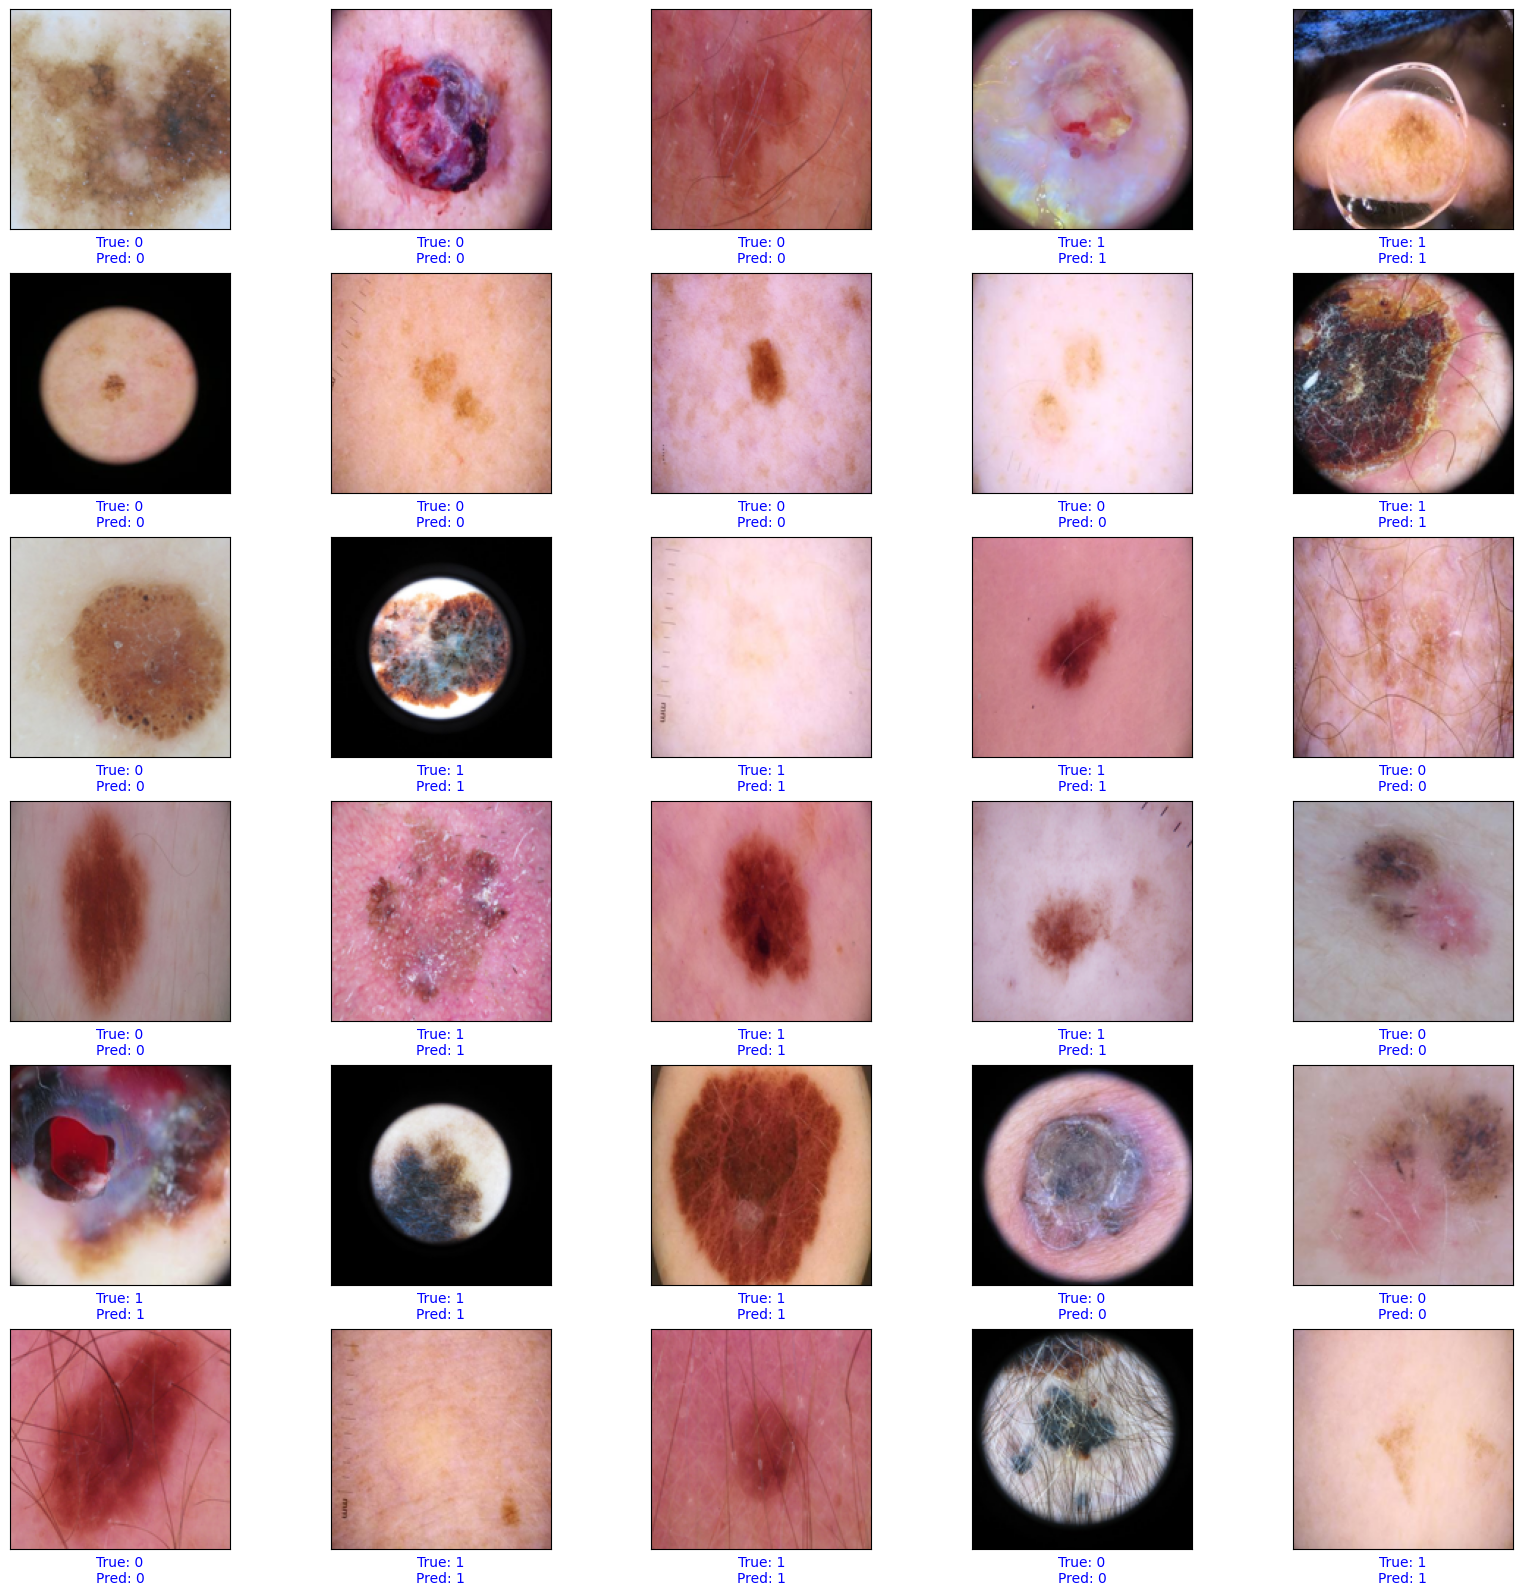

In [34]:
# Muestra los primeros 30 imágenes con la categoría real y el valor que predice el modelo
plt.figure(figsize=(20, 20))
for i in range(30):
    plt.subplot(6, 5, i + 1)  # Ajusta el número de filas y columnas según sea necesario
    cmap_image = "binary" if predicted_labels[i] == y_pred2[i] else "Oranges"
    plt.imshow(images_batch[i], cmap=cmap_image)
    plt.xticks([])
    plt.yticks([])
    c = "blue" if predicted_labels[i] == y_pred2[i] else "red"
    plt.xlabel(f"True: {predicted_labels[i]}\nPred: {y_pred2[i]}", color=c)


plt.show()

In [35]:
y_diff = np.equal(predicted_labels, y_pred2)
y_diff[y_diff==False].size
indices = np.where(y_diff == False)
indices = indices[0]

32
[]


<ipython-input-59-a26c33fbc8b6>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model4.predict_generator(test_generator)


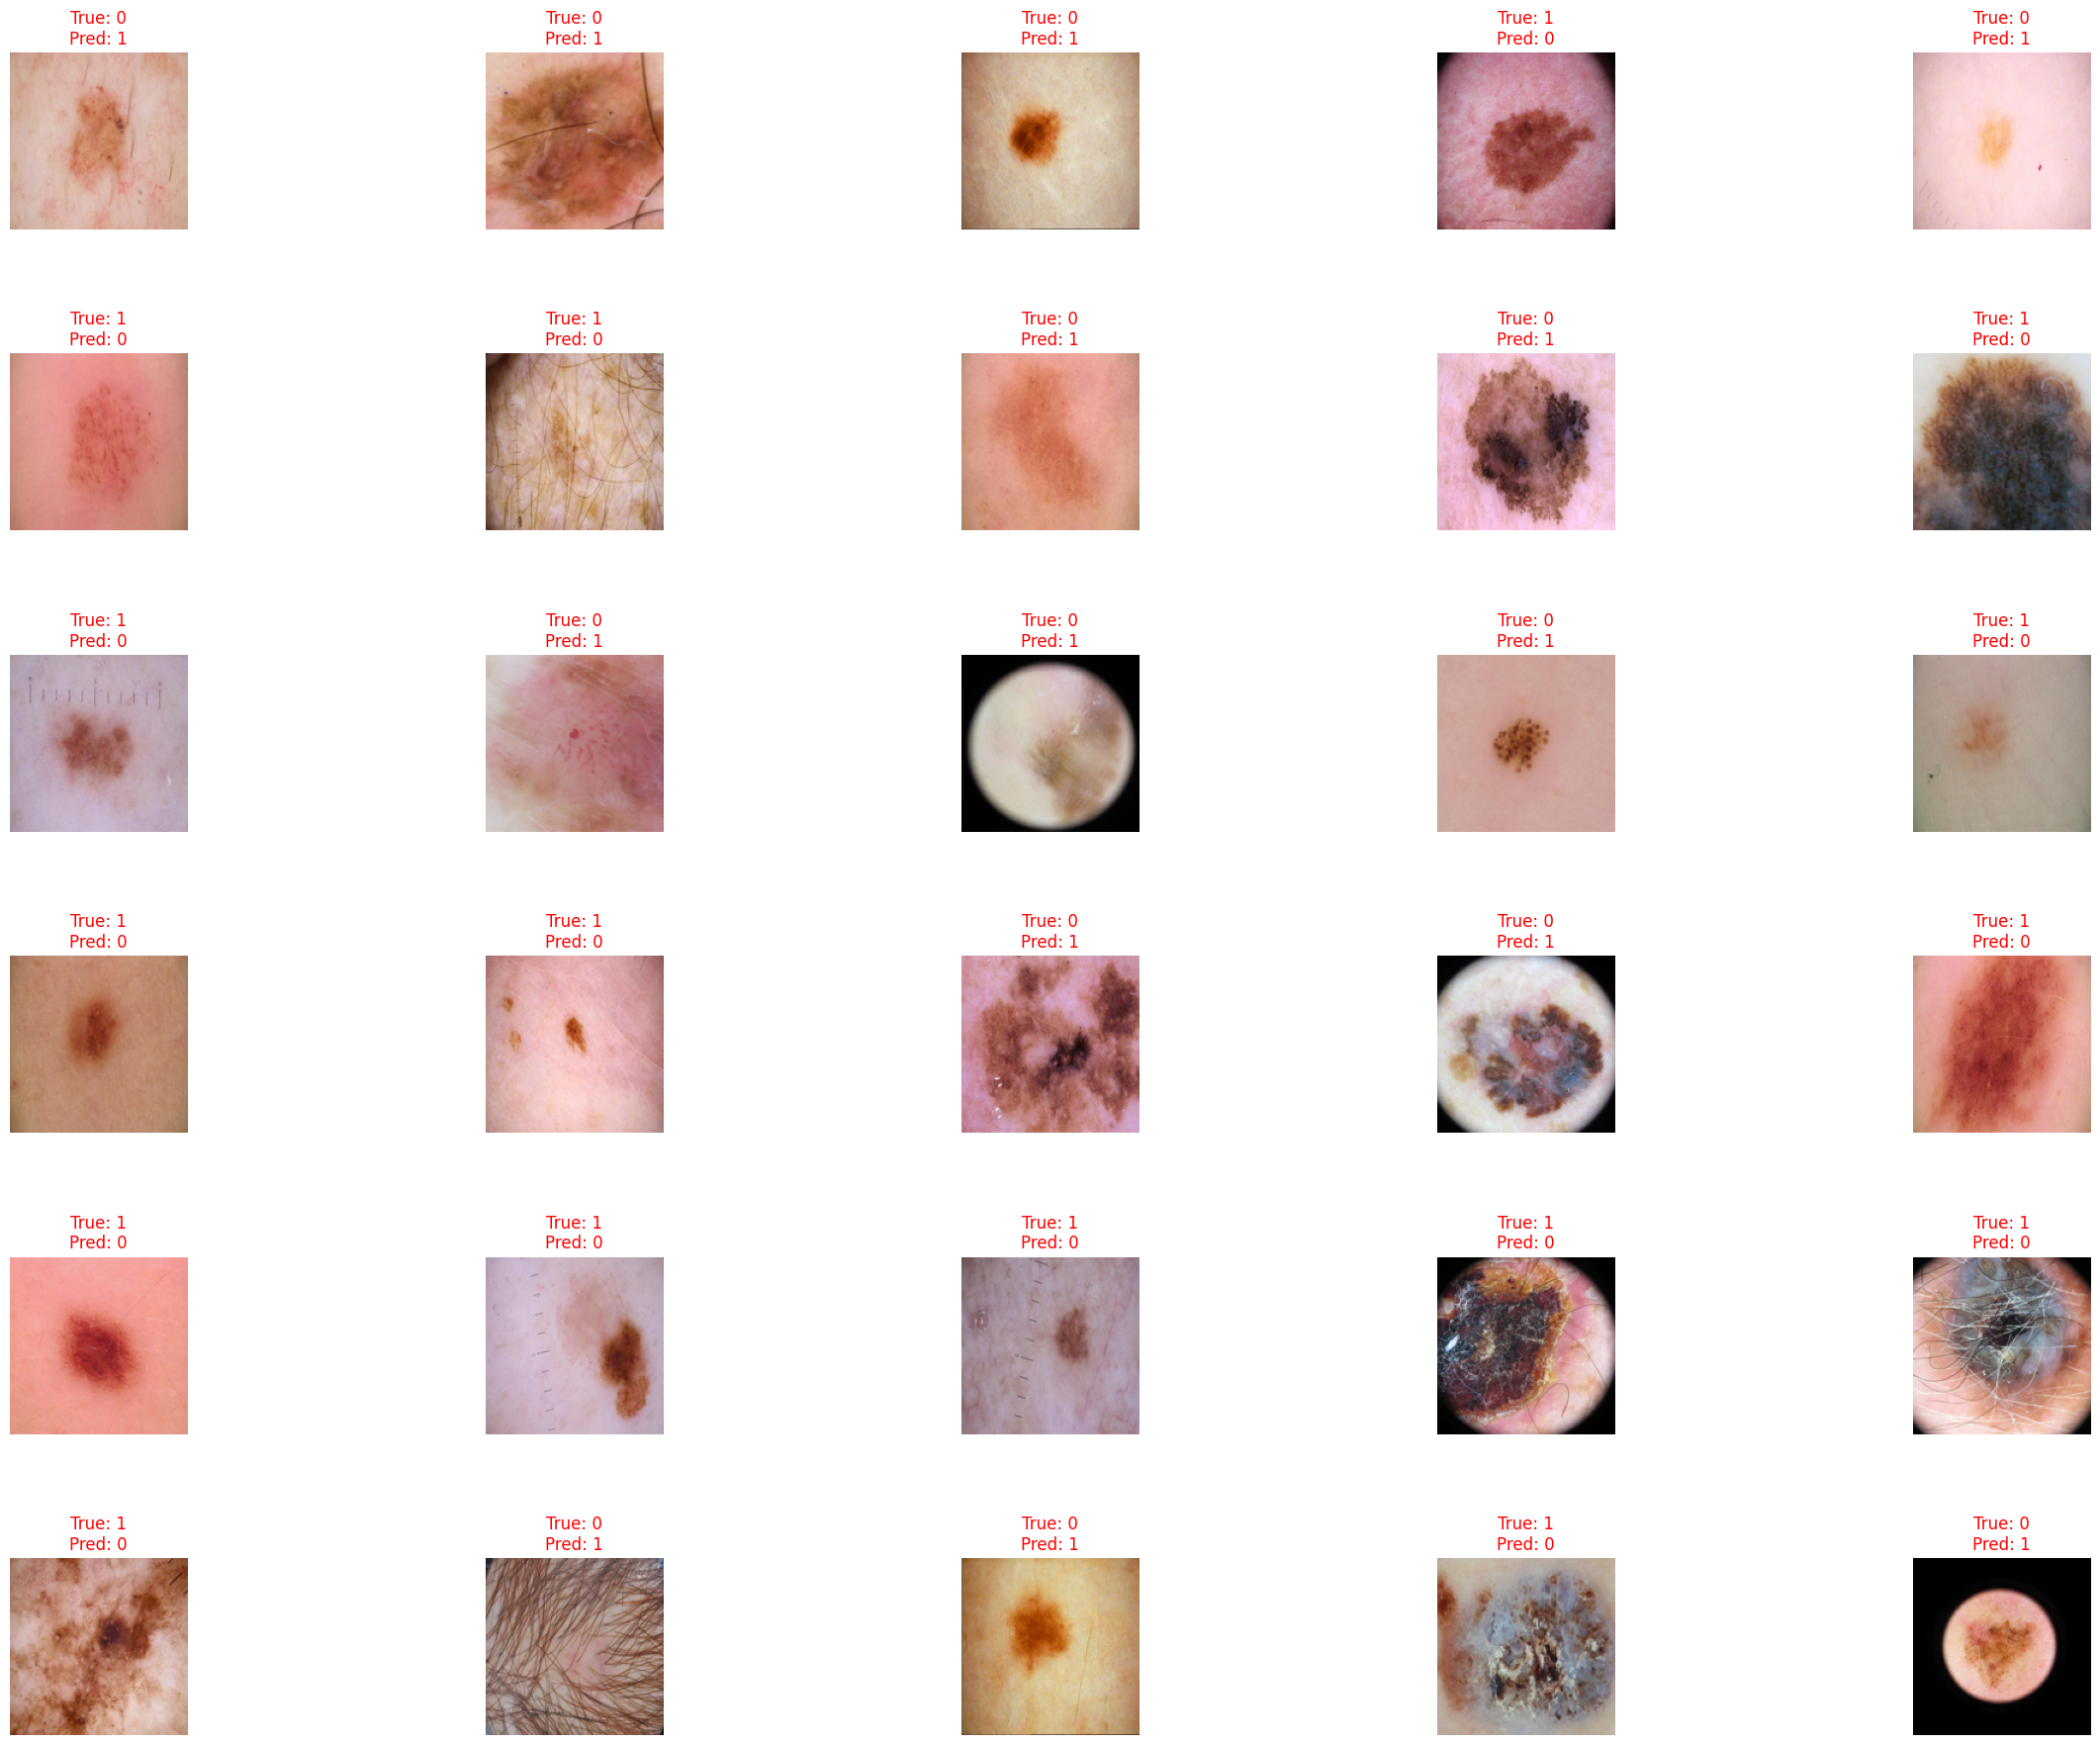

In [59]:
test_generator.reset()

predictions = model4.predict_generator(test_generator)

y_true = predicted_labels

y_pred = predictions.argmax(axis=1)
indices_mal_clasificadas = np.where(y_true != y_pred)[0]

total_imagenes = len(indices_mal_clasificadas)
filas = 8
columnas = 5

# Establecer el número máximo de imágenes a mostrar (30 o el total de imágenes mal clasificadas, el que sea menor)
max_imagenes_mostrar = min(30, total_imagenes)

plt.figure(figsize=(30, 30))
for i in range(max_imagenes_mostrar):
    images_batch, labels_batch = test_generator.next()

    imagen_mal_clasificada = images_batch[0]

    plt.subplot(filas, columnas, i + 1)  # Ajusta el número de filas y columnas según sea necesario
    plt.imshow(imagen_mal_clasificada, cmap="Oranges")
    plt.title(f"True: {y_true[indices_mal_clasificadas[i]]}\nPred: {y_pred[indices_mal_clasificadas[i]]}", color="red")
    plt.axis('off')

plt.subplots_adjust(hspace=0.7)
plt.show()


## Importando el modelo.

In [ ]:
# Ruta al archivo .h5
ruta_archivo = '/content/best_model_checkpoint.h5'

# Carga el modelo
modelo4 = load_model(ruta_archivo)


## Probar el modelo con una imagen.

In [ ]:
# Cargar una imagen de prueba (asegúrate de tener imágenes en el formato y tamaño adecuado)
imagen_prueba_path = '/content/drive/MyDrive/benigna1.jpg'
imagen_prueba = Image.open(imagen_prueba_path)
imagen_prueba = imagen_prueba.resize((150, 150))  # Ajusta el tamaño según el modelo

# Convertir la imagen a un formato adecuado para la predicción
imagen_array = np.array(imagen_prueba)
imagen_array = imagen_array / 255.0  # Normalizar los valores de píxeles entre 0 y 1
imagen_array = np.expand_dims(imagen_array, axis=0)  # Agregar una dimensión de lote

# Realizar la predicción
prediccion = modelo4.predict(imagen_array)

# Imprimir la predicción
print("Probabilidad de clase:", prediccion)
print("Probabilidad de clase benigna:", prediccion[0, 0])
print("Probabilidad de clase maligna:", prediccion[0, 1])

# Clasificación final basada en la probabilidad más alta
clase_predicha = np.argmax(prediccion)
if clase_predicha == 0:
    print("La imagen es benigna.")
else:
    print("La imagen es maligna.")


1/1 [==============================] - 0s 27ms/step
Probabilidad de clase: [[0.9185264  0.08147353]]
Probabilidad de clase benigna: 0.9185264
Probabilidad de clase maligna: 0.08147353
La imagen es benigna.


Hemos hecho una comprobacion de una imagen individual y podemos ver que a funcionado correctamente predicciendo la clase benigna con un 0.91 frente a la clase maligana con un 0.081

## Conclusion.

Nuestra conclusión es que contamos con un sólido modelo de clasificación de imágenes, alcanzando un impresionante 95,58%. No obstante, dado que estamos tratando con un ámbito médico, reconocemos que siempre es preferible alcanzar porcentajes más altos, ya que la precisión es fundamental en este tipo de contextos. En consecuencia, buscamos continuamente mejorar y perfeccionar nuestro modelo para garantizar la máxima exactitud en la clasificación de imágenes médicas.